In [2]:
# import statements
import utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [3]:
# Loading data

# Fake data
articles = np.asarray([
    ["Donald Trump buys a dog", "Donald Trump recently was found buying a dog"],
    ["President Trump gets a corgie", "The White House welcomes a new furry friend, and its name is Evan!"],
    ["U.S. Presidential Paws", "You won't believe the new dog that Donald and the fam just got!"],
    ["Biden sells his old car", "President Biden just announced that he is selling is '96 Civic"],
    ["President Biden to sell car", "Biden announced via Twitter that he will indeed be selling his car"],
    ["Biden getting that car cash", "Biden is about to cash out once he sells that junker civic!"]
])

data = utils.toframe(utils.files)

In [4]:
data.head()

,article_id,title,abstract,author,source,time_stamp,link,query
0,-6606275897906588298,Three Men Are Accused in Scheme to Sell Covid-...,Prosecutors said the men created a fake duplic...,By Concepción de León,The New York Times,2021-02-12T22:09:48+0000,https://www.nytimes.com/2021/02/12/us/baltimor...,moderna
1,-759365642050973959,"Covid Vaccines for Kids Are Coming, but Not fo...",Pfizer and Moderna are testing their vaccines ...,By Apoorva Mandavilli,The New York Times,2021-02-12T10:00:21+0000,https://www.nytimes.com/2021/02/12/health/covi...,moderna
2,-7222055656088273670,"Where Do Vaccine Doses Go, and Who Gets Them? ...",Health agencies and hospitals are using differ...,By Natasha Singer,The New York Times,2021-02-07T19:37:49+0000,https://www.nytimes.com/2021/02/07/technology/...,moderna
3,2612876733188800864,It’s Time to Trust China’s and Russia’s Vaccines,"They, too, work, and they can help fill shorta...",By Achal Prabhala and Chee Yoke Ling,The New York Times,2021-02-05T10:00:58+0000,https://www.nytimes.com/2021/02/05/opinion/cov...,moderna
4,-3252507377201141967,Russian Campaign Promotes Homegrown Vaccine an...,Russian news outlets with connections to the K...,"By Sheera Frenkel, Maria Abi-Habib and Julian ...",The New York Times,2021-02-05T16:09:45+0000,https://www.nytimes.com/2021/02/05/technology/...,moderna


In [27]:
# Vectorizing 
roberta = SentenceTransformer('stsb-roberta-base')
a = [x + ': ' + y for x,y in zip(data['title'][0:100], data['abstract'][0:100])]
v = utils.encode(a, roberta)

Time for computting embeddings:7.246684551239014


In [28]:
# Retrieving related articles 

In [29]:
# Creating the graph
import networkx as nx

G = nx.Graph()

In [30]:
G.clear()
for root, v0 in zip(data['title'], v):
    for comp, v1 in zip(data['title'], v):
        if utils.doc_sim(v0,v1) > .5:
            G.add_edge(root, comp, weight=utils.doc_sim(v0,v1))

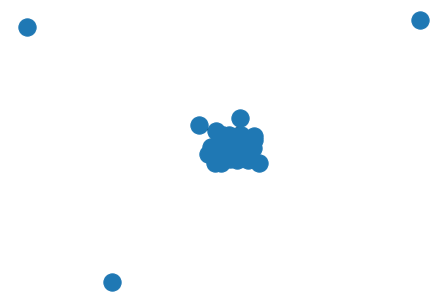

In [31]:
nx.draw(G)

In [32]:
from networkx.algorithms import community
from networkx import edge_betweenness_centrality as betweenness

def most_central_edge(G):

    centrality = betweenness(G, weight="weight")

    return max(centrality, key=centrality.get)

comp = community.girvan_newman(G, most_valuable_edge=most_central_edge)

communities =tuple(sorted(c) for c in next(comp))

In [33]:
# Extracting full articles from communities
cdf = []
for com in communities:
    df = pd.DataFrame()
    for art in com:
        x = data.loc[data['title'] == art]
        df = df.append(x)
    cdf.append(df)

In [34]:
# Reducing each community down to an article 
min_coms = [] 
for com in cdf:
    min_time = min(com['time_stamp'])
    df = pd.DataFrame()
    df = df.append(com.loc[com['time_stamp'] == min_time])
    min_coms.append(df)

In [35]:
el = nx.Graph()
el.clear()

# Generating Lv and Huang graph 
lv = sorted([(x,list(x['time_stamp'])) for x in min_coms], key = lambda x: x[1])
lv = [x[0] for x in lv]
for i in range(1, len(lv)):
    el.add_edge(str(lv[i-1]['title']), str(lv[i]['title']))

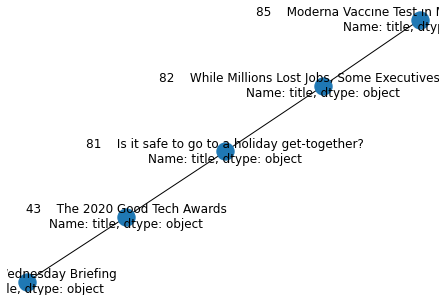

In [36]:
# Drawing the graph 
%matplotlib inline
nx.draw_kamada_kawai(el, with_labels=True)

In [37]:
# Generating NewsChain event line 

# Defining similarity between sub-events 
# Similarity = avg_pairwise_eos 
# Rules for drawing edge, if sim > theta, draw directed edge based on min time 
el.clear()
